In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Exercice 1.



Solve the Stokes equations with FEniCS:

\begin{alignat}{2}
-\nabla\cdot\sigma(u, p) &= f \quad && \text{in } \Omega \\
\nabla\cdot u &= 0 \quad && \text{in } \Omega \\
u &= u_{\mathrm{L}} \quad && \text{on } \Gamma_{\mathrm{L}} \\
p &= p_{\mathrm{R}} \quad && \text {on } \Gamma_{\mathrm{R}} \\
u &= (0,0) \quad && \text{on } \Gamma_0 \\
\end{alignat}

where $\sigma(u) = 2\mu\varepsilon(u) - pI$ is the viscous stress tensor, $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$ is the strain tensor (symmetric gradient) and $I$ is the identity matrix.



Use the following data to solve the problem:

* $\Omega$ defined by the mesh `airfoil_exterior.xml`

From: http://rs1.szif.hu/~lotfi/Numerical-Methods/airfoil_exterior.xml

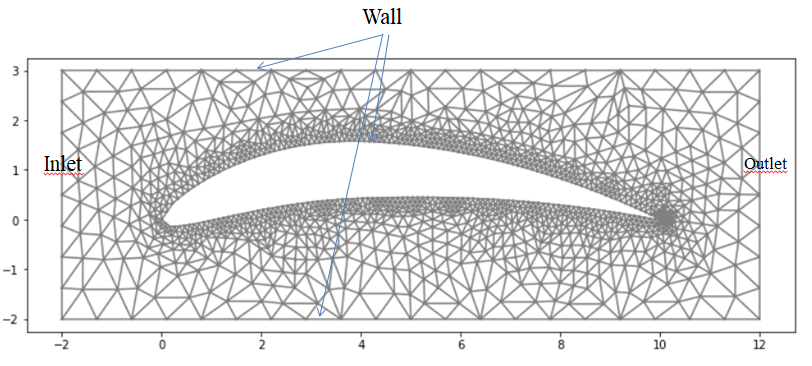


* $f = (0,0)$
* $\Gamma_{\mathrm{L}} = \{(x,y) \in \partial\Omega \,\vert\, x = -2\}$ (the left boundary)
* $\Gamma_{\mathrm{R}} = \{(x,y) \in \partial\Omega \,\vert\, x = 12\}$ (the right boundary)
* $\Gamma_{0} = \partial\Omega \setminus (\Gamma_{\mathrm{L}} \cup \Gamma_{\mathrm{R}})$ (the wall: no-slip boundary condition)
* $p_{\mathrm{L}} = 0$ (outflow)
* $u_{\mathrm{R}} = (10.0, 0.0)$ (inflow)
* $\mu = 0.1$ (dynamic viscosity)

In [ ]:
import requests


url = 'http://rs1.szif.hu/~lotfi/Numerical-Methods/airfoil_exterior.xml'
r = requests.get(url, allow_redirects=True)

open('dolfin_coarse.xml', 'wb').write(r.content)

287855

In [ ]:
!ls

dolfin_coarse.xml  dolfin_coarse.xml.gz  sample_data


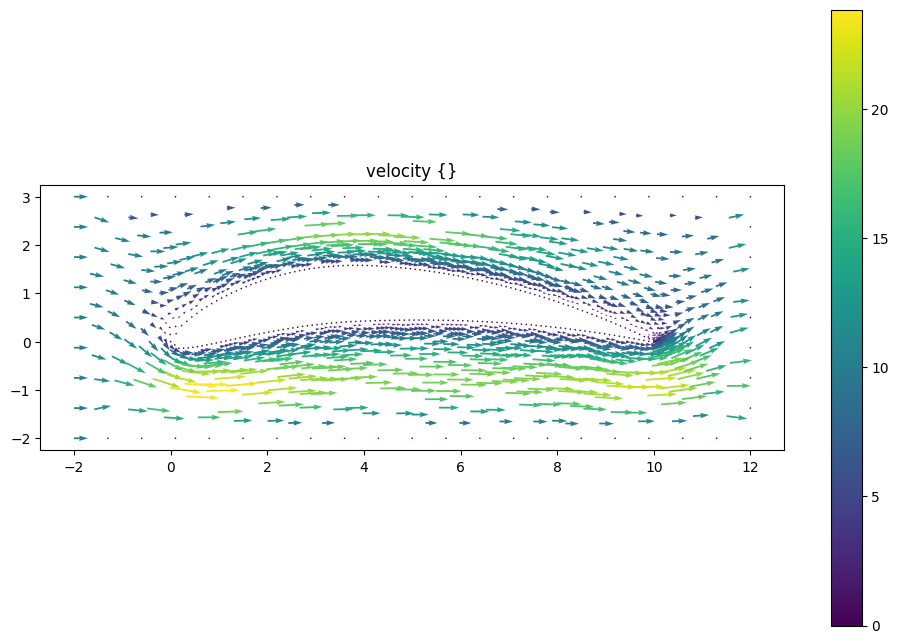

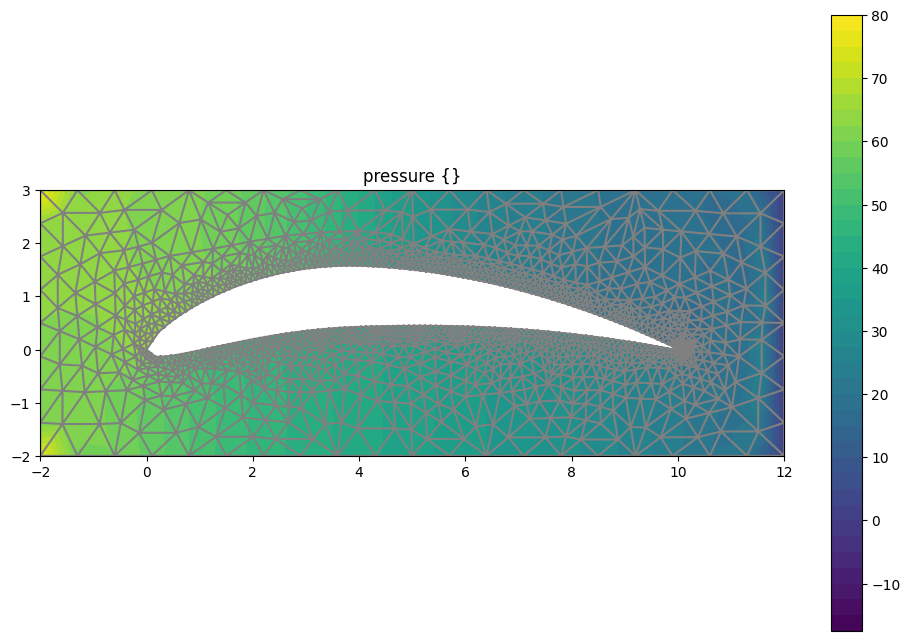

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

mesh = Mesh('dolfin_coarse.xml')

# Problem data
#u_in = Expression(("4.0*U*x[1]*(0.41 - x[1])/(0.41*0.41)", "0.0"),degree=2, U=1.5)
p_L = Constant(0)
u_in = Expression(('10.0', '0.0'), degree=2)
mu = Constant(0.1)

# Define function spaces (Taylor-Hood)
P2 = VectorElement('CG', triangle, 2)  # Velocity --> degree = 2
P1 = FiniteElement('CG', triangle, 1)  # Pressure --> degree = 1
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)

# Construct boundaries
bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

# define boundaries for the subdomain
# walls
def Left( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0]+2) < tol)

def Right( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[0] - 12) < tol)

def Top( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1] - 3) < tol)

def Bottom( x, on_boundary):
      tol = 1E-14
      return (on_boundary and abs(x[1]+2) < tol)


# inflow
def inflow( x, on_boundary):
    tol = 1E-14
    return on_boundary and abs(x[0]+2) < tol


# outflow
def Outflow( x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0]- 12) < tol

# dolphain
def Dolphain( x, on_boundary):
      tol = 1E-14
      return on_boundary and not any(b(x, on_boundary) for b in [Left, Right, Bottom, Top])


# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=bndry)


# Dirichlet boundary conditions
#  No-slip boundary
bc1 = DirichletBC(W.sub(0), (0,0), Top)
bc2 = DirichletBC(W.sub(0), (0,0), Bottom)
bc3 = DirichletBC(W.sub(0), (0,0), Left)
bc4 = DirichletBC(W.sub(0), (0,0), Right)
bc5 = DirichletBC(W.sub(0), u_in, inflow)
bc6 = DirichletBC(W.sub(1), p_L, Outflow)
bc7 = DirichletBC(W.sub(0), (0,0), Dolphain)

bcs = [bc1, bc2, bc3, bc4, bc5, bc6, bc7]

# Solve steady Stokes
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)


# Define variational forms
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(Constant((0, 0)), v)*dx + dot(Constant((0, 0)), v)*ds

# Solve the problem
w = Function(W)
solve(a == L, w, bcs)

u, p = w.split()
# Plot
plt.figure(figsize=(12,8))
pl = plot(u, title='velocity {}')
plt.colorbar(pl)
plt.figure(figsize=(12,8))
pl = plot(p, title='pressure {}')
plt.colorbar(pl)

plot(mesh)

## Exercice 2.

Solve the 2D linear Elasticity with FEniCS:

$$
-\nabla \cdot \sigma = f\hbox{ in }\Omega,
$$
$$
\sigma {\bf n} = {\bf g} \text{ on } \Gamma_{top},
$$
$$
 u =  0 \text{ on }  \Gamma_{bottom},
$$

where

\begin{equation}
{\sigma}({\bf u})= \lambda({\nabla}\cdot {\bf u}){I} + \mu({\nabla} \boldsymbol{\bf u} + ({\nabla} {\bf u})^T),
\end{equation}

$\lambda$, $\mu$ are the Lamé coefficients describing the mechanical properties of the material, that are related
to the Young’s modulus $E$ and Poisson’s ratio $\nu$ as follows:

$$
 \lambda = \dfrac{E\nu}{(1+\nu)(1-2\nu)}, \quad \mu = \dfrac{E}{2(1+\nu)}.
$$

Use the following data to solve the problem:

* The domain $\Omega$ is shown in the following figure:

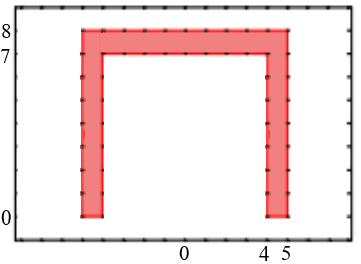

* Young's modulus and Poisson's ratio:

$$ E = 200.e6, \quad nu = 0.3.$$

* The load:
  1. $$f = 0$$
  2. $${\bf g} = (0.0,-100.0)$$




**Tips:** Take the advantage of symmetry to simplify the finite element model.

* symmetry boundary condition:

$$
 u_x =  0.0 \text{ on }  \Gamma_{left}.
$$

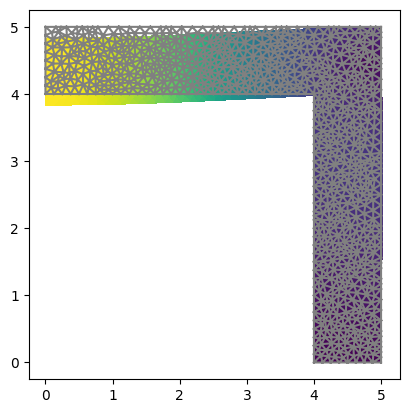

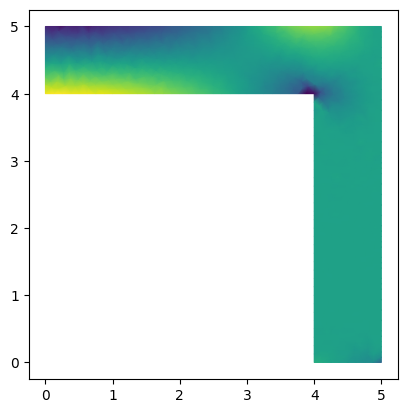

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
%matplotlib inline
L_x, L_y = 5., 4.
L = 8.0
N = 40 # mesh density

domain = Rectangle(Point(0.,0.), Point(L_x, L_x)) - Rectangle(Point(0., 0.), Point(L_y, L_y))
mesh = generate_mesh(domain, N)

# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
    return (on_boundary and near(x[0], 0.0))

def bottom(x, on_boundary):
    return (on_boundary and near(x[1], 0.0))

# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  200e6      #210e9
nu = 0.3

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc1 = DirichletBC(V.sub(0), Constant((0.0)), left)
bc2 = DirichletBC(V, Constant((0.0, 0.0)), bottom)
bc = [bc1, bc2]
#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
top = AutoSubDomain(lambda x: near(x[1], L_x))

top.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

# Load
# Weight density
rho_g = 0
#  Unform vertical loading due to self-weight
f = Constant((0.,-rho_g))
# surface load
g = Constant((0.0, -100.0))

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(g, v)*ds(1)

# Solve the variational problem
u = Function(V)
solve(a == L, u, bc)

# Plot Deformed Shape
plt.figure()
factor = 1000
plot(factor*u, mode="displacement")
plot(mesh)

# Plot stress σxx
plt.figure()
plot(sigma(u)[0,0], mode='color')
plt.show()


In [ ]:
from dolfin import *
import numpy as np
from mshr import *
import matplotlib.pyplot as plt
%matplotlib inline

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
plot(mesh)

# Define the finite element space
V = FunctionSpace(mesh, 'P', 1)